In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk

In [20]:
from prep_hashes import contractions
import re
import random
from nltk.tokenize import RegexpTokenizer

stopwords = ['stop', 'the', 'to', 'and', 'a', 'in', 'it', 'is', 'I', 'that', 'had', 'on', 'for', 'were', 'was']

def preprocess_text(review: str) -> str:
    # make everything lowercase
    review = review.lower()

    # convert contractions to fully written form
    review = review.split(' ')
    for i in range(len(review)):
        try:
            exp_form = contractions[f"{review[i]}"]

            if '/' in exp_form:
                exp_form = exp_form.split('/')[random.randint(0, len(exp_form.split('/'))-1)]

            review[i] = exp_form
        except KeyError:
            pass

    review = ' '.join(review).strip()

    # remove punctuation
    tokenizer = RegexpTokenizer(r'\w+')
    tokenized = tokenizer.tokenize(review)
    review = ' '.join(tokenized).strip()
    # re.sub("[^a-zA-Z]+", " ", review).strip()

    review = review.replace("i m", "i am")

    # removing stop words
    review = review.split(' ')
    denoised_rev = [] 
    for i in range(len(review)):
        if review[i] not in stopwords:
            denoised_rev.append(review[i])
    
    review = ' '.join(denoised_rev)

    return review

In [21]:
# model_data = pd.read_csv('./data/model_data.csv')
model_data = pd.read_csv('./data/Musical_instruments_reviews.csv')
model_data = model_data.dropna()

# rev = model_data['Translated_Review']
rev = list(model_data['reviewText'])

# preprocessing text
for i in range(len(rev)):
    rev[i] = preprocess_text(rev[i])

df = pd.DataFrame({
    'Review': rev,
    'Rating': model_data['overall'] # model_data['Rating']
})
df = df.dropna()
df

,Review,Rating
0,not much write about here but does exactly wha...,5.0
1,product does exactly as should quite affordabl...,5.0
2,primary job of this device block breath would ...,5.0
3,nice windscreen protects my mxl mic prevents p...,5.0
4,this pop filter great looks performs like stud...,5.0
...,...,...
10256,great just as expected thank all,5.0
10257,i have been thinking about trying nanoweb stri...,5.0
10258,i have tried coated strings past including eli...,4.0
10259,well made by elixir developed with taylor guit...,4.0


(array([ 216.,    0.,  249.,    0.,    0.,  771.,    0., 2079.,    0.,
        6912.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

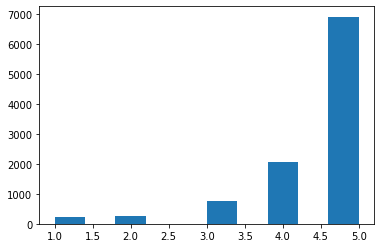

In [22]:
plt.hist(df['Rating'])

In [23]:
# TEXT TO SEQUENCES 

import torch
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import AG_NEWS

train_iter = iter(AG_NEWS(split='train'))

tokenizer = get_tokenizer('basic_english')
train_iter = AG_NEWS(split='train')

def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

In [16]:
# CREATE SEQUENCE DATASET 
from sklearn.model_selection import train_test_split

# find most common words
words = list(df["Review"])
words = pd.DataFrame(' '.join(words).strip().split(' '))

top_100 = [w[0] for w in words.value_counts()[:100].index.to_list()]

reviews = list(df["Review"])
sequences = []
for i in range(len(reviews)):
    seq = vocab(reviews[i].split(' '))

    sequences.append(seq)

seqs = []
max_seq_len = 100 # max(map(len, sequences))
for i in range(len(sequences)):
    try:
        while len(sequences[i]) < max_seq_len:
            sequences[i].insert(0, 0)
        while len(sequences[i]) >  max_seq_len:
            sequences[i].pop(random.randint(0, len(sequences[i])-1))
        sequences[i] = np.array(sequences[i])
    except TypeError:
        pass

y = np.array(list(df['Rating']))

data = np.array(sequences)

ny = []
# for i in range(len(y)):
#     ny.append((np.array([j+1 for j in range(5)]) == y[i])*1)
# y = ny

y = np.array(list(df['Rating']))/5

X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2, random_state=40)
print(X_train.shape)
print(X_train[0].shape)

(8181, 100)
(100,)


In [24]:
import gensim.downloader as api

embeddings_api = api.load('glove-wiki-gigaword-100')

In [25]:
# CREATE EMBEDDING MATRIX

embedding_matrix = np.zeros((len(top_100), 100))

for i in range(len(embedding_matrix)):
    embedding_vector = embeddings_api[top_100[i]]
    embedding_matrix[i] = embedding_vector

print(embedding_matrix.shape)

(100, 100)


In [26]:
# test data and embedding matrix dimensions

np.dot(X_train[0], embedding_matrix)

array([ -88827.47261214,   52932.56317673,   39656.25718291,
        -65481.60068638,  -11416.7099419 ,   -1502.18551715,
        -73505.11853117,   91431.72896874,  -56708.88102082,
        -74419.03056814,   61870.91710804,  -39233.38254305,
         18706.50572685,    2548.67124609,  -34969.13375655,
        -45925.10569099,   27174.32293374,  -32909.69186741,
        -32060.26508506,  120605.64032517,   29019.62513384,
          3574.97703315,   61366.10959528,  -21104.37425462,
          1330.84545455,  -76821.74550194,  -39479.0472283 ,
        -72423.23528569,   21050.1408202 ,  -19277.88622888,
        -48197.335047  ,  174663.42258715,   33739.21232575,
         56478.9397625 ,  107260.70236691,   83647.99016144,
       -113852.99327716,   93164.61961722,   71092.19133074,
       -110506.24737308,  -64757.80528593,  -57667.0243663 ,
        -64676.68278522,  -24602.02494561,  -44579.44085353,
          3223.90066878,  -30071.29693939, -110917.36074533,
         -4220.45843928,

In [27]:
print(embedding_matrix.dtype)
embedding_matrix = embedding_matrix.astype(np.float64)
print(embedding_matrix.dtype)
device = torch.device("cpu")

float64
float64


In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class NN(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        # self.embed_layer = torch.nn.Parameter(data=torch.Tensor(embedding_matrix), requires_grad=True)
        # self.embed_layer = nn.Embedding(100, 100)
        # print(embedding_matrix.dtype)
        # self.embed_layer.weights = torch.nn.Parameter(torch.tensor(embedding_matrix))
        self.l1 = nn.Linear(100, 32)
        self.out = nn.Linear(32, 1)# 5)
    
    def forward(self, x):
        # print(x.to(device).long())
        # x = x.to(device).long()
        # print(x)
        # x = self.embed_layer(x)
        x = x.cpu().detach().numpy()
        x = embedding_matrix @ x
        # print(x.shape)
        x = F.relu(torch.Tensor(x))

        x = torch.flatten(x)

        x = self.l1(x)
        x = F.relu(x)

        x = self.out(x)
        x = torch.sigmoid(x)

        return x

In [29]:
print(X_train[0].shape)
model = NN(input_size=X_train[0].shape)

(100,)


In [35]:
count = 0

class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))

criterion = nn.MSELoss() # CrossEntropyLoss() # nn.MSELoss() # RMSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.1)

losses = []

for t_X, y in zip(X_train, y_train):
    t_X = torch.Tensor(t_X)
    y = torch.Tensor([y])

    preds = model(t_X)

    # max_val = float('-inf')
    # max_idx = 0
    # for i in range(len(preds)):
    #     if preds[i] > max_val:
    #         max_val = preds[i]
    #         max_idx = i

    # for i in range(len(y[0])):
    #     if y[0][i] == 1:
    #         lidx = i
    
    # label = (y==1).nonzero(as_tuple=True)[0]
    # pred_class = (preds==1).nonzero(as_tuple=True)[0]
    

    # if list(pred_class.size())[0] > 1:
    #     pred_class = pred_class[random.randint(0, len(pred_class)-1)]

    # pred_class = torch.Tensor([pred_class])

    # print(label.cpu().detach().numpy().dtype)
    # print(pred_class.cpu().detach().numpy().dtype)

    # loss = criterion(torch.Tensor([max_idx]), torch.Tensor([lidx]))
    loss = criterion(preds, y)
    losses.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f"[ Data Pt {count} Loss {loss.item()} ]")

    count += 1

    if count == 1000:
        break

[ Data Pt 0 Loss 1.0 ]
[ Data Pt 1 Loss 0.0 ]
[ Data Pt 2 Loss 0.64000004529953 ]
[ Data Pt 3 Loss 1.0 ]
[ Data Pt 4 Loss 1.0 ]
[ Data Pt 5 Loss 0.0 ]
[ Data Pt 6 Loss 0.0 ]
[ Data Pt 7 Loss 1.0 ]
[ Data Pt 8 Loss 0.64000004529953 ]
[ Data Pt 9 Loss 0.36000001430511475 ]
[ Data Pt 10 Loss 1.0 ]
[ Data Pt 11 Loss 0.64000004529953 ]
[ Data Pt 12 Loss 0.1600000113248825 ]
[ Data Pt 13 Loss 0.0 ]
[ Data Pt 14 Loss 0.0 ]
[ Data Pt 15 Loss 0.0 ]
[ Data Pt 16 Loss 1.0 ]
[ Data Pt 17 Loss 0.0 ]
[ Data Pt 18 Loss 0.64000004529953 ]
[ Data Pt 19 Loss 1.0 ]
[ Data Pt 20 Loss 0.15999998152256012 ]
[ Data Pt 21 Loss 1.0 ]
[ Data Pt 22 Loss 0.0 ]
[ Data Pt 23 Loss 1.0 ]
[ Data Pt 24 Loss 0.03999999538064003 ]
[ Data Pt 25 Loss 0.36000001430511475 ]
[ Data Pt 26 Loss 1.0 ]
[ Data Pt 27 Loss 0.0 ]
[ Data Pt 28 Loss 0.1600000113248825 ]
[ Data Pt 29 Loss 0.03999999538064003 ]
[ Data Pt 30 Loss 0.64000004529953 ]
[ Data Pt 31 Loss 0.1600000113248825 ]
[ Data Pt 32 Loss 0.0 ]
[ Data Pt 33 Loss 1.0 ]
[ Da

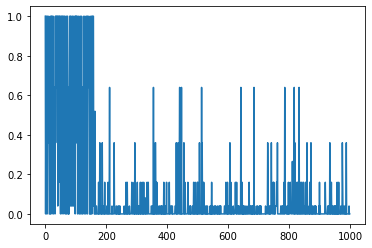

In [36]:
plt.plot([i for i in range(len(losses))], losses)

In [37]:
torch.save(model.state_dict(), f'./model')

In [38]:
nmodel = NN(input_size=100)
nmodel.load_state_dict(torch.load('./model'))

total_loss = 0

max_loss = float('-inf')
for i in range(len(X_test)):
    X = torch.Tensor(X_test[i])
    pred = nmodel(X)

    curr_loss = ((pred) - (y_test[i])) ** 2 

    total_loss += curr_loss

    if curr_loss > max_loss:
        max_loss = curr_loss

print(max_loss)
print(total_loss)
print(f"avg loss per pred {total_loss/(len(y_test))}")

tensor([0.6400], grad_fn=<PowBackward0>)
tensor([90.7495], grad_fn=<AddBackward0>)
avg loss per pred tensor([0.0444], grad_fn=<DivBackward0>)


In [39]:
crev = "The product does exactly as it should and is quite affordable.I did not realized it was double screened until it arrived, so it was even better than I had expected.As an added bonus, one of the screens carries a small hint of the smell of an old grape candy I used to buy, so for reminiscent's sake, I cannot stop putting the pop filter next to my nose and smelling it after recording. :DIf you needed a pop filter, this will work just as well as the expensive ones, and it may even come with a pleasing aroma like mine did!Buy this product! :]"
crev = "I'm a pro-cheapo and I hated this thing. They're noisy, and the cables feel really cheap, gummy-like. Drop few more bucks and get something else!"

test_ex = vocab(preprocess_text(crev).split(" "))
while len(test_ex) < 100:
    test_ex.insert(0, 0)
print(nmodel(torch.Tensor(test_ex))*5)

tensor([5.], grad_fn=<MulBackward0>)
